In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


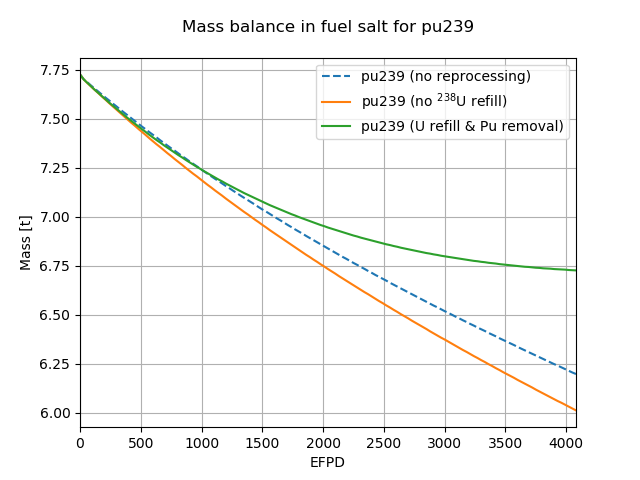

<IPython.core.display.Javascript object>


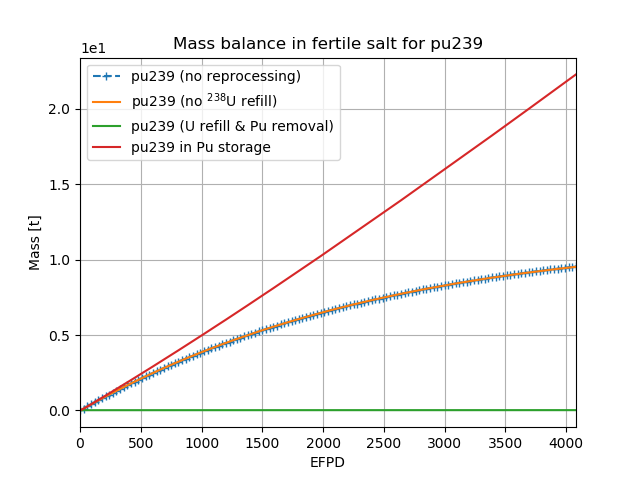

<IPython.core.display.Javascript object>


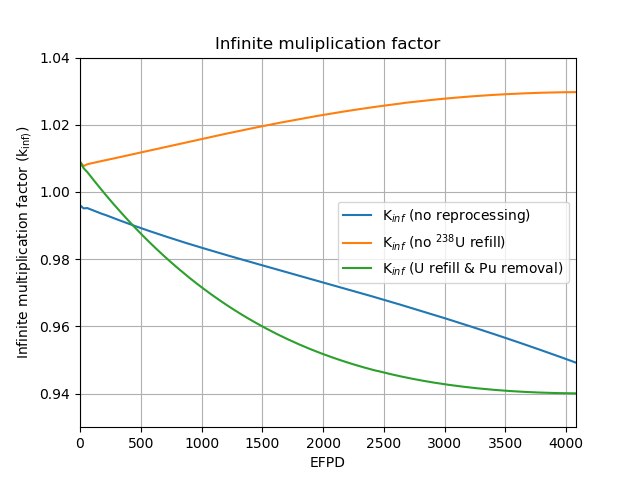

No refill

Breeding gain 698.6502853094363 kg/year
Breeding gain coefficient 0.09041503742387497
Breeding gain in blanket 2846.290627627766 kg/year
Doubling time (net) 11.060107129214552 yrs
pu239 inventory in driver at the beginning and end of cycle [7.727146728359762, 6.725984360251768] t
pu239 inventory in blanket at the beginning and end of cycle [2.976882965327404e-16, 0.017917773743937153] t

Normalization coefficient for driver (fuel) 97.29408919199035
Normalization coefficient for blanket (fertile) 441.2110757772155


In [11]:
%matplotlib notebook 
# Import modules
import numpy as np
import matplotlib.pyplot
from pyne import serpent
from pyne import nucname
from scipy.stats.stats import pearsonr 
from scipy.stats import linregress
import itertools
##################################################################################################
##### Normalization coefficient for driver (fuel)     97.29472420072297 MTIHM
##### Normalization coefficient for blanket (fertile) 441.2158071612657 MTIHM
###################################################################################################
#vol_fuel_se    = [38.0E+6]
#vol_blank_se   = [75.0E+6]

vol_fuel_se   = [67.79968/6.968485e-1]# MTIHM for T=0 / Normalized HM mass (t) from *.out [97.29472420072297]
vol_blank_se  = [133.75523/3.031515e-1]#[441.2158071612657]
vol_pu_storage= [133.75523/3.031515e-1]#[133.75523/3.031515e-1]
iso = 'pu239'
# SCALE output
# No reprocessing case
filename_fuel0  = '/home/andrei2/Desktop/ornl/mcsfr/scale/no_reproc_depl/4080efd/mcsfr_no_move_4080d.000000000000000000.plt'
filename_blank0 = '/home/andrei2/Desktop/ornl/mcsfr/scale/no_reproc_depl/4080efd/mcsfr_no_move_4080d.000000000000000001.plt'
k_file0 = '/home/andrei2/Desktop/ornl/mcsfr/scale/no_reproc_depl/4080efd/mcsfr_no_move_4080d.out'
# No feed case, no Pu removal from blanket
filename_fuel4  = '/home/andrei2/Dropbox/study/internships/ornl/science/forAndrei/onlyRemovals/4080d/mcsfr/mcsfr_opus_after.000000000000000000.plt'
filename_blank4 = '/home/andrei2/Dropbox/study/internships/ornl/science/forAndrei/onlyRemovals/4080d/mcsfr/mcsfr_opus_after.000000000000000001.plt'
k_file4 = '/home/andrei2/Dropbox/study/internships/ornl/science/forAndrei/onlyRemovals/4080d/mcsfr/mcsfr_all_removals_no_feeds.out'
# U238 feed in both, Pu removal from blanket
filename_fuel_feed  = '/home/andrei2/Dropbox/study/internships/ornl/science/forAndrei/mcsfr2/mcsfr_opus_after.000000000000000000.plt'
filename_blank_feed = '/home/andrei2/Dropbox/study/internships/ornl/science/forAndrei/mcsfr2/mcsfr_opus_after.000000000000000001.plt'
filename_pu     = '/home/andrei2/Dropbox/study/internships/ornl/science/forAndrei/mcsfr2/mcsfr_opus_after.000000000000000002.plt'
k_file_feed = '/home/andrei2/Dropbox/study/internships/ornl/science/forAndrei/mcsfr2/mcsfr_all_removal_u_feed_4080d.out'

def read_scale_out (filename):
    iso       = []
    adens     = []
    days_list = []
    with open(filename,'r') as infile:
        for line in itertools.islice(infile, 5, None):  # Skip file header start=6, stop=None
            p = line.split()
            iso.append(str(p[0]))
            adens.append(p[1:])  
            #iso.append(str(p[2]))
            #adens.append(str(p[3]))
    #u_en = 1e-6* np.flip (np.array (upp_enrg, dtype=float), 0 )               # Convert eV to MeV
    #flux = np.flip ( np.array (flux_list, dtype=float), 0 )
    #num_gr = len (u_en)
    days_list.append (iso[0])
    days_list = days_list + adens[0][:]
    adens_arr = np.asarray(adens[1:][:], dtype=np.float32)
    days = np.array (days_list, dtype=np.float32)
    return iso[1:], days, adens_arr/1e+6

def read_scale_k (filename):
    kinf = []
    with open(filename) as openfile:
        for line in openfile:
            if line.startswith('      Infinite neutron multiplication'):
                num = line.split(' ')[-1].strip()
                kinf.append(float(num))
    return kinf[1:]

def heavy_metal_mass (iso_name, days, mdens, vol):
    iso = []
    mthm = 0.0
    for k in range (len(iso_name)-2):
        if nucname.znum(iso_name[k]) > 89:
            iso.append(iso_name[k])
            mthm += mdens[k] * vol
    return mthm

kinf0 = read_scale_k (k_file0)
kinf4     = read_scale_k (k_file4)
kinf_feed = read_scale_k (k_file_feed)

# No reproc case
n_sc0, days_sc, mdens_fuel_sc0          = read_scale_out (filename_fuel0)
n_sc_blanket0, days_sc, mdens_blank_sc0 = read_scale_out (filename_blank0)

# No feed case
n_sc4, days_sc, mdens_fuel_sc4          = read_scale_out (filename_fuel4)
n_sc_blanket4, days_sc, mdens_blank_sc4 = read_scale_out (filename_blank4)

# Feed and Pu removal case
n_f_feed, days_sc, mdens_f_feed          = read_scale_out (filename_fuel_feed)
n_b_feed, days_sc, mdens_b_feed          = read_scale_out (filename_blank_feed)
n_sc_pu, days_sc_pu, mdens_pu            = read_scale_out (filename_pu)

MTHM_fuel                               = heavy_metal_mass (n_sc4, days_sc, mdens_fuel_sc4,vol_fuel_se[0])
MTHM_blanket                            = heavy_metal_mass (n_sc_blanket4, days_sc, mdens_blank_sc4,vol_blank_se[0])
MTHM_pu                                 = heavy_metal_mass (n_sc_pu, days_sc, mdens_pu,vol_blank_se[0])

tot_m_no  = mdens_fuel_sc4[n_sc4.index(iso),]*vol_fuel_se[0]+mdens_blank_sc4[n_sc_blanket4.index(iso),]*vol_blank_se[0]
tot_m_feed= mdens_f_feed[n_f_feed.index(iso),]*vol_fuel_se[0]+mdens_b_feed[n_b_feed.index(iso),]*vol_blank_se[0]+mdens_pu[n_sc_pu.index(iso),]*vol_pu_storage[0]
#print (tot_mass_sc)
#print (mdens_fuel_sc4[n_sc4.index(iso),0]*vol_fuel_se[0])
#print (mdens_blank_sc4[n_sc_blanket4.index(iso),0]*vol_blank_se[0])
#gain_rate = 1e-3*365*(tot_mass_sc[-1] - tot_mass_sc[0])/days_sc[-1]

# Initialize figure
fig_1 = matplotlib.pyplot.figure(1)
ax = fig_1.add_subplot(111)
ax.grid(True)
ax.ticklabel_format (style='sci',scilimits=(0,0),axis='y')
#ax.set_ylim(0,0.00555)
#for i in [n_se.index(iso.capitalize())]:
    #ax.plot(days, mdens_fuel_se[i,:]*vol_fuel_se[0], '-',color='#ff8100', label=nucname.serpent(n_se[i])+' (no removals)')
    #ax.plot(days, mdens_fuel_se[i,:]*vol_fuel_se[0]+mdens_blank_se[i,:]*vol_blank_se[0], '--',color='#ff8100',
    #        label=nucname.serpent(n_se[i])+'(w/ blanket, no removals)')
    #ax.plot(days, mdens_blank_se[i,:]*vol_blank_se[0], '-',color='#ff8100', label=nucname.serpent(n_se[i])+'(Serpent, blanket)')
#for i in [n_se1.index(iso.capitalize())]:
#    ax.plot(days, mdens_fuel_se1[i,:]*vol_fuel_se[0], '-',color='red',
#            label=nucname.serpent(n_se1[i])+' Serpent(gases removal)')
#for i in [n_se2.index(iso.capitalize())]:
#    ax.plot(days, mdens_fuel_se2[i,:]*vol_fuel_se[0], '--',color='green', 
#            label=nucname.serpent(n_se2[i])+' Serpent(volatile gases, noble metals, \nrare earths&discard)')
#for k in [iso]:
#    ax.plot(days_sc, mdens_fuel_sc[n_sc.index(k)]*vol_fuel_se[0], '-',color='#ff8100', label=k+'(no removals)')
#for k in [iso]:
#    ax.plot(days_sc, mdens_fuel_sc1[n_sc1.index(k)]*vol_fuel_se[0], '+--',color='blue', label=k+'(gases)')
#for k in [iso]:
#    ax.plot(days_sc, mdens_fuel_sc2[n_sc2.index(iso)]*vol_fuel_se[0], '-',color='black', label=k+'(gases&noble)')
for k in [iso]:
    ax.plot(days_sc, mdens_fuel_sc0[n_sc0.index(k)]*vol_fuel_se[0], '--', label=k+' (no reprocessing)')
for k in [iso]:
    ax.plot(days_sc, mdens_fuel_sc4[n_sc4.index(k)]*vol_fuel_se[0], '-', label=k+' (no $^{238}$U refill)')
for k in [iso]:
    ax.plot(days_sc, mdens_f_feed[n_f_feed.index(k)]*vol_fuel_se[0], '-', label=k+' (U refill & Pu removal)')
#for k in [iso]:
#    ax.plot(days_sc, mdens_fuel_sc4[n_sc4.index(k)]*vol_fuel_se[0]+mdens_blank_sc4[n_sc_blanket4.index(k)]*vol_blank_se[0], 
#            '-', label='Total')
ax.legend(loc=0)
ax.set_ylabel('Mass [t]')
ax.set_xlabel('EFPD')
ax.set_title('Mass balance in fuel salt for ' + str (iso)+'\n')
ax.set_xlim([0,np.amax(days_sc)])
#ax.set_xlim ([0,320*3])
#ax.set_ylim([0, np.amax(tot_mass_sc)])
fig_1.show()
#fig_1.savefig(str(iso)+'_core.png',bbox_inches='tight', dpi=900)

# Initialize figure
fig_2 = matplotlib.pyplot.figure(2)
ax = fig_2.add_subplot(111)
ax.grid(True)
ax.ticklabel_format (style='sci',scilimits=(0,0),axis='y')
#for i in [n_se.index(iso.capitalize())]:
#    ax.plot(days, mdens_blank_se[i,:]*vol_blank_se[0], '-',color='#ff8100', label=nucname.serpent(n_se[i])+' (no removals)')
#for i in [n_se1.index(iso.capitalize())]:
#    ax.plot(days, mdens_blank_se1[i,:]*vol_blank_se[0], '-',color='red', label=nucname.serpent(n_se1[i])+' Serpent(gases removal)')
#for i in [n_se2.index(iso.capitalize())]:
#    ax.plot(days, mdens_blank_se2[i,:]*vol_blank_se[0], '--',color='blue', label=nucname.serpent(n_se2[i])+' Serpent(volatile gases, noble metals, \nrare earths&discard)')
#for k in [iso]:
#    ax.plot(days_sc, mdens_blank_sc[n_sc_blanket.index(k)]*vol_blank_se[0], '-',color='#ff8100', label=k+'(no removals)')
#for k in [iso]:
#    ax.plot(days_sc, mdens_blank_sc1[n_sc_blanket1.index(k)]*vol_blank_se[0], '+--',color='blue', label=k+'(gases)')
#for k in [iso]:
#    ax.plot(days_sc, mdens_blank_sc2[n_sc_blanket2.index(k)]*vol_blank_se[0], '-',color='black', label=k+'(gases&noble)')
for k in [iso]:
    ax.plot(days_sc, mdens_blank_sc0[n_sc_blanket0.index(k)]*vol_blank_se[0], '+--',label=k+' (no reprocessing)')
for k in [iso]:
    ax.plot(days_sc, mdens_blank_sc4[n_sc_blanket4.index(k)]*vol_blank_se[0], '-', label=k+' (no $^{238}$U refill)')
for k in [iso]:
    ax.plot(days_sc, mdens_b_feed[n_b_feed.index(k)]*vol_blank_se[0], '-', label=k+' (U refill & Pu removal)')
for k in [iso]:
    ax.plot(days_sc, mdens_pu[n_sc_pu.index(k)]*vol_pu_storage[0], '-', label=k+' in Pu storage')
ax.legend(loc=0)
ax.set_ylabel('Mass [t]')
ax.set_xlabel('EFPD')
ax.set_title('Mass balance in fertile salt for ' + str (iso))
ax.set_xlim([0,np.amax(days_sc)])
#ax.set_xlim ([0,3*320])
#ax.set_ylim ([0,0.5])
fig_2.show()
#fig_2.savefig(str(iso)+'_blanket.png',bbox_inches='tight', dpi=700)

# Initialize figure
fig_4 = matplotlib.pyplot.figure(4)
ax = fig_4.add_subplot(111)
ax.grid(True)
#ax.plot(days_sc, kinf0, '-',color='#ff8100', label='no removals')
#ax.plot(days_sc, kinf1, '-',color='blue', label='gases')
#ax.plot(days_sc, kinf2, '-',color='black', label='gases&noble')
#ax.plot(days_sc, kinf3, '-',color='red', label='gases&noble\n&rare earths')
ax.plot(days_sc, kinf0, '-', label='K$_{inf}$ (no reprocessing)')
ax.plot(days_sc, kinf4, '-', label='K$_{inf}$ (no $^{238}$U refill)')
ax.plot(days_sc, kinf_feed, '-', label='K$_{inf}$ (U refill & Pu removal)')
ax.legend(loc=0)
ax.set_ylabel('Infinite multiplication factor (k$_{\inf)}$)')
ax.set_xlabel('EFPD')
ax.set_title('Infinite muliplication factor')
ax.set_xlim([0,np.amax(days_sc)])
#ax.set_xlim ([0,960])
ax.set_ylim ([0.93, 1.04])
fig_4.show()
#fig_4.savefig('k_inf_Th_feed.png',bbox_inches='tight', dpi=700)
'''
# Initialize figure
fig_5 = matplotlib.pyplot.figure(5)
ax = fig_5.add_subplot(111)
ax.grid(True)
ax.plot(days_sc, MTHM_fuel, '-',color='green', label='MTHM in core')
ax.plot(days_sc, MTHM_blanket, '-',color='blue', label='MTHM in blanket')
#ax.plot(days_sc, MTHM_pu, '-',color='#ff8100', label='MTHM in Pu tank')
ax.legend(loc=0)
ax.set_ylabel('Metric tons')
ax.set_xlabel('EFPD')
ax.set_title('Heavy Metal Loading')
ax.set_xlim([0,np.amax(days_sc)])
fig_4.show()
#fig_4.savefig('k_inf_Th_feed.png',bbox_inches='tight', dpi=700)
'''
print ('No refill\n')

print ('Breeding gain ' + str (1e+3*365*(tot_m_no[-1]-tot_m_no[0])/days_sc[-1]) + ' kg/year' )
print ('Breeding gain coefficient ' + str (365*(tot_m_no[-1] - tot_m_no[0])/(tot_m_no[0] * days_sc[-1])) )
print ('Breeding gain in blanket ' + str (1e+3*365*(mdens_blank_sc4[n_sc_blanket4.index(iso),-1]*vol_blank_se[0] + mdens_pu[n_sc_pu.index(iso),-1]*vol_pu_storage[0])/days_sc[-1]) + ' kg/year' )
print ('Doubling time (net) ' + str( 1/(365*(tot_m_no[-1] - tot_m_no[0])/(tot_m_no[0] * days_sc[-1]))  ) + ' yrs')

##print (tot_mass_sc[-1] - tot_mass_sc[0])
print (str(iso)+' inventory in driver at the beginning and end of cycle '+ 
       str ([mdens_f_feed[n_f_feed.index(iso),0]*vol_fuel_se[0],
            mdens_f_feed[n_f_feed.index(iso),-1]*vol_fuel_se[0]])  + ' t' )
print (str(iso)+' inventory in blanket at the beginning and end of cycle '+ 
       str ([mdens_b_feed[n_b_feed.index(iso),0]*vol_blank_se[0],
            mdens_b_feed[n_b_feed.index(iso),-1]*vol_blank_se[0]])  + ' t' )
#print (mdens_fuel_sc4[n_sc_blanket4.index(iso),0]*vol_fuel_se[0])

print('\nNormalization coefficient for driver (fuel) ' + str (MTHM_fuel[0]/6.968485e-1)    )
print('Normalization coefficient for blanket (fertile) ' + str (MTHM_blanket[0]/3.031515e-1)    )